In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/2025-2학기/text/new data')
os.listdir()

['가정폭력+발생현황_seoul(2023).xlsx',
 '경찰청 강원특별자치도경찰청_가정폭력 범죄 검거 현황_20241231.csv',
 '경찰청_시도청별 가정폭력검거및조치현황_20241231.csv',
 '빅카인즈_가정폭력_20210101-20250919.xlsx']

In [3]:
import pandas as pd

# 빅카인즈
bk = pd.read_excel("빅카인즈_가정폭력_20210101-20250919.xlsx")

bk['date'] = pd.to_datetime(bk['일자'], format='%Y%m%d')
bk['year'] = bk['date'].dt.year
bk['month'] = bk['date'].dt.to_period('M')

if '분석제외 여부' in bk.columns:
    bk = bk[bk['분석제외 여부'] != '중복']

bk_year = bk.groupby('year').size().reset_index(name='기사수')

bk_month = bk[bk['year'] == 2023].groupby('month').size().reset_index(name='기사수_2023')
bk_year, bk_month

(   year  기사수
 0  2021   71
 1  2022   63
 2  2023   73
 3  2024   46
 4  2025   45,
       month  기사수_2023
 0   2023-01         4
 1   2023-02         9
 2   2023-03         4
 3   2023-04         5
 4   2023-05         8
 5   2023-06        12
 6   2023-07         8
 7   2023-08         1
 8   2023-09        11
 9   2023-10         8
 10  2023-11         1
 11  2023-12         2)

In [4]:
occ = pd.read_excel("가정폭력+발생현황_seoul(2023).xlsx")

occ_sel = occ[(occ["구분별(1)"] == "신고건수") & (occ["구분별(2)"] == "소계")]

month_cols = [col for col in occ_sel.columns if "2023" in col]

occ_month = occ_sel.melt(
    value_vars=month_cols,
    var_name='month',
    value_name='신고건수'
)

occ_month['month'] = occ_month['month'].str.replace(" ", "")
occ_month['month'] = pd.to_datetime(occ_month['month'], format="%Y.%m").dt.to_period("M")

occ_month

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,month,신고건수
0,2023-01,3486
1,2023-02,2984
2,2023-03,3601
3,2023-04,3528
4,2023-05,3302
5,2023-06,3401
6,2023-07,3501
7,2023-08,3517
8,2023-09,3403
9,2023-10,3289


In [5]:
month_merge = bk_month.merge(occ_month, on='month', how='left')
month_merge

,month,기사수_2023,신고건수
0,2023-01,4,3486
1,2023-02,9,2984
2,2023-03,4,3601
3,2023-04,5,3528
4,2023-05,8,3302
5,2023-06,12,3401
6,2023-07,8,3501
7,2023-08,1,3517
8,2023-09,11,3403
9,2023-10,8,3289


In [6]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.3 MB/s eta 0:00:00


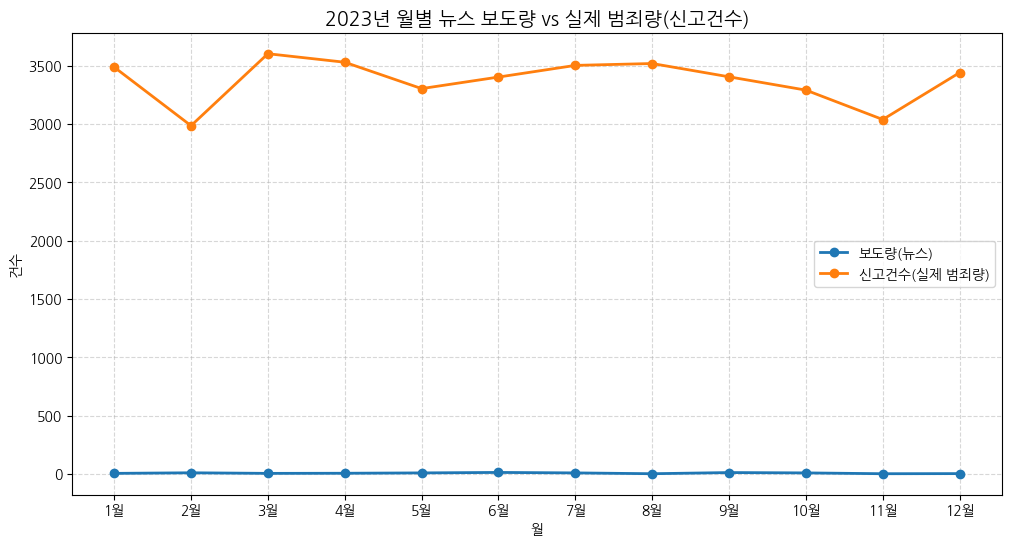

In [7]:
month_merge['월'] = month_merge['month'].dt.month.astype(int)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(month_merge['월'], month_merge['기사수_2023'], marker='o', linewidth=2, label='보도량(뉴스)')
plt.plot(month_merge['월'], month_merge['신고건수'], marker='o', linewidth=2, label='신고건수(실제 범죄량)')

plt.xticks(range(1, 13), labels=[f"{m}월" for m in range(1, 13)])
plt.title("2023년 월별 뉴스 보도량 vs 실제 범죄량(신고건수)", fontsize=14)
plt.xlabel("월")
plt.ylabel("건수")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [8]:
!pip install beautifulsoup4 tqdm lxml koreanize-matplotlib

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

In [10]:
def extract_article_data(url, press_name):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        title_element = soup.select_one(
            ".content90 h1, .article-wrap01 h1, h1.tit, "
            ".title01, .article-tit"
        )
        title = title_element.get_text(strip=True) if title_element else ""

        if not title:
            meta_title = soup.find("meta", property="og:title")
            if meta_title:
                title = meta_title.get("content")

        paragraphs = []
        for selector in ["#articleWrap p", "#articeBody p", "div#article_body p"]:
            for p in soup.select(selector):
                txt = p.get_text(" ", strip=True)
                if len(txt) > 10:
                    paragraphs.append(txt)
        content = " ".join(paragraphs)

        year_match = re.search(r"20\d{2}", url)
        year = int(year_match.group()) if year_match else None

        return {
            "year": year,
            "press": press_name,
            "title": title,
            "content": content,
            "url": url,
        }

    except Exception as e:
        print("오류: {url} → {e}")
        return None

In [12]:
import re

def extract_urls_from_rtf(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    urls = re.findall('https?://[^\s"}]+', text)
    urls = list(dict.fromkeys(urls))  # 중복 제거
    return urls

path_jtbc = "/content/drive/MyDrive/2025-2학기/text/jtbc.rtf"
path_yna  = "/content/drive/MyDrive/2025-2학기/text/yna.rtf"

jtbc_urls = extract_urls_from_rtf(path_jtbc)
yna_urls = extract_urls_from_rtf(path_yna)

print("JTBC URL 개수:", len(jtbc_urls))
print("연합뉴스 URL 개수:", len(yna_urls))

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-618390535.py:6: SyntaxWarning: invalid escape sequence '\s'
  urls = re.findall('https?://[^\s"}]+', text)


JTBC URL 개수: 67
연합뉴스 URL 개수: 366


In [13]:
import pandas as pd

df_jtbc = pd.DataFrame({"url": jtbc_urls})
df_yna = pd.DataFrame({"url": yna_urls})

save_jtbc = "/content/drive/MyDrive/2025-2학기/text/jtbc_urls.csv"
save_yna  = "/content/drive/MyDrive/2025-2학기/text/yna_urls.csv"

df_jtbc.to_csv(save_jtbc, index=False, encoding="utf-8-sig")
df_yna.to_csv(save_yna, index=False, encoding="utf-8-sig")

print("✔ CSV 저장 완료!")
print("JTBC →", save_jtbc)
print("YNA  →", save_yna)

✔ CSV 저장 완료!
JTBC → /content/drive/MyDrive/2025-2학기/text/jtbc_urls.csv
YNA  → /content/drive/MyDrive/2025-2학기/text/yna_urls.csv


In [14]:
def extract_year(url):
    match = re.search(r"20\d{2}", url)
    return int(match.group()) if match else None

df_jtbc["year"] = df_jtbc["url"].apply(extract_year)
df_yna["year"] = df_yna["url"].apply(extract_year)

news_all = pd.concat([df_jtbc, df_yna], ignore_index=True)

news_year = (
    news_all.dropna(subset=["year"])
            .groupby("year")
            .size()
            .reset_index(name="news_count")
)

news_year

,year,news_count
0,2021.0,42
1,2022.0,33
2,2023.0,92
3,2024.0,107
4,2025.0,92
5,2040.0,1
6,2042.0,1
7,2046.0,1
8,2066.0,1
9,2068.0,2


In [16]:
import pandas as pd

# 경찰청 데이터(시도청별)
pol = pd.read_csv("경찰청_시도청별 가정폭력검거및조치현황_20241231.csv", encoding='cp949')

pol.head()

,연도,검거건수,검거총인원,구속인원,불구속인원,가정보호사건 송치
0,2017,38583,45264,384,44880,15979
1,2018,41905,43576,355,43221,14689
2,2019,50277,59472,490,58982,21228
3,2020,44459,52431,330,52101,19379
4,2021,46041,53985,410,53575,24867


In [17]:
# 1) 빅카인즈 연도별 기사수 정리
bk_year = bk.groupby('year').size().reset_index(name='기사수')

# 기간 맞추기(뉴스는 2021~2025 기준)
bk_year = bk_year[bk_year['year'] >= 2021]

bk_year

,year,기사수
0,2021,71
1,2022,63
2,2023,73
3,2024,46
4,2025,45


In [18]:
# 경찰청 실제 가정폭력 검거 건수 (있는 연도만 자동 사용)

import pandas as pd

pol = pd.read_csv("경찰청_시도청별 가정폭력검거및조치현황_20241231.csv", encoding='cp949')

pol_year = pol[['연도','검거건수']].copy()

pol_year['연도'] = pd.to_numeric(pol_year['연도'], errors='coerce')

pol_year = pol_year.groupby('연도')['검거건수'].sum().reset_index()

pol_year = pol_year.rename(columns={
    '연도': 'year',
    '검거건수': '실제범죄건수'
})

pol_year = pol_year[(pol_year['year'] >= 2021) & (pol_year['year'] <= 2025)]

pol_year.sort_values('year')

,year,실제범죄건수
4,2021,46041
5,2022,44816
6,2023,44524
7,2024,37905


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 빅카인즈 연도 데이터
bk = pd.read_excel("빅카인즈_가정폭력_20210101-20250919.xlsx")
bk['date'] = pd.to_datetime(bk['일자'], format='%Y%m%d')
bk['year'] = bk['date'].dt.year

bk_year = bk.groupby('year').size().reset_index(name='빅카인즈')

# 연합뉴스 CSV (크롤링 결과 - df_yna 사용)
yna_year = df_yna.groupby('year').size().reset_index(name='연합뉴스')

# JTBC CSV (크롤링 결과 - df_jtbc 사용)
jtbc_year = df_jtbc.groupby('year').size().reset_index(name='JTBC')

# 경찰청 실제 범죄(검거) 건수
pol_year = pol_year[['year','실제범죄건수']]

In [22]:
# 모든 연도 합치기
merged = (
    bk_year
    .merge(yna_year, on='year', how='outer')
    .merge(jtbc_year, on='year', how='outer')
    .merge(pol_year, on='year', how='outer')
    .sort_values('year')
)

merged

,year,빅카인즈,연합뉴스,JTBC,실제범죄건수
0,2021.0,82.0,42.0,NaN,46041.0
1,2022.0,75.0,33.0,NaN,44816.0
2,2023.0,87.0,92.0,NaN,44524.0
3,2024.0,52.0,107.0,NaN,37905.0
4,2025.0,56.0,92.0,NaN,NaN
5,2040.0,NaN,NaN,1.0,NaN
6,2042.0,NaN,NaN,1.0,NaN
7,2046.0,NaN,NaN,1.0,NaN
8,2066.0,NaN,NaN,1.0,NaN
9,2068.0,NaN,NaN,2.0,NaN


In [24]:
merged['year'] = merged['year'].astype(float)

# 2021~2025만 남기기
merged = merged[(merged['year'] >= 2021) & (merged['year'] <= 2025)]
merged = merged.sort_values('year')
merged

,year,빅카인즈,연합뉴스,JTBC,실제범죄건수
0,2021.0,82.0,42.0,NaN,46041.0
1,2022.0,75.0,33.0,NaN,44816.0
2,2023.0,87.0,92.0,NaN,44524.0
3,2024.0,52.0,107.0,NaN,37905.0
4,2025.0,56.0,92.0,NaN,NaN


In [25]:
merged['뉴스총보도량'] = merged[['빅카인즈', '연합뉴스', 'JTBC']].sum(axis=1)
merged

,year,빅카인즈,연합뉴스,JTBC,실제범죄건수,뉴스총보도량
0,2021.0,82.0,42.0,NaN,46041.0,124.0
1,2022.0,75.0,33.0,NaN,44816.0,108.0
2,2023.0,87.0,92.0,NaN,44524.0,179.0
3,2024.0,52.0,107.0,NaN,37905.0,159.0
4,2025.0,56.0,92.0,NaN,NaN,148.0


In [29]:
def extract_article_data(url, press_name):
    import requests, re
    from bs4 import BeautifulSoup

    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        # 제목 추출

        title_element = soup.select_one(
            ".content90 h1, .article-tit, h1.tit, h1.title, .title01"
        )
        title = title_element.get_text(strip=True) if title_element else ""

        if not title:
            meta_title = soup.find("meta", property="og:title")
            if meta_title:
                title = meta_title.get("content", "")

        # 본문 추출
        paragraphs = []
        for selector in [
            "#articleWrap p",
            "div#article_body p",
            "div.artical_body p",
        ]:
            for p in soup.select(selector):
                txt = p.get_text(" ", strip=True)
                if len(txt) > 10:
                    paragraphs.append(txt)

        content = " ".join(paragraphs)

        # 연도 추출
        year = None

        date_tag = soup.select_one("span.date, div.date, .article_info .date")
        if date_tag:
            date_text = date_tag.get_text(strip=True)
            year_match = re.search(r"(20\d{2})", date_text)
            if year_match:
                year = int(year_match.group(1))

        if not year:
            year_match = re.search(r"(20\d{2})", url)
            if year_match:
                year = int(year_match.group(1))

        return {
            "year": year,
            "press": press_name,
            "title": title,
            "content": content,
            "url": url,
        }

    except Exception as e:
        print(f"오류 발생: {url} → {e}")
        return None

In [30]:
import requests, re
from bs4 import BeautifulSoup
import pandas as pd

def extract_article_data(url, press_name):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        # 제목
        title_element = soup.select_one(
            ".content90 h1, .article-tit, h1.tit, h1.title, .title01"
        )
        title = title_element.get_text(strip=True) if title_element else ""

        if not title:
            meta_title = soup.find("meta", property="og:title")
            if meta_title:
                title = meta_title.get("content", "")

        # 본문
        paragraphs = []
        for selector in ["#articleWrap p", "div#article_body p", "div.artical_body p"]:
            for p in soup.select(selector):
                txt = p.get_text(" ", strip=True)
                if len(txt) > 10:
                    paragraphs.append(txt)
        content = " ".join(paragraphs)

        # 연도 추출
        year = None
        date_tag = soup.select_one("span.date, div.date, .article_info .date")
        if date_tag:
            date_text = date_tag.get_text(strip=True)
            match = re.search(r"(20\d{2})", date_text)
            if match:
                year = int(match.group(1))

        if not year:
            match = re.search(r"(20\d{2})", url)
            if match:
                year = int(match.group(1))

        return {
            "year": year,
            "press": press_name,
            "title": title,
            "content": content,
            "url": url,
        }

    except Exception as e:
        print("오류: {url} → {e}")
        return None

In [31]:
jtbc_urls = pd.read_csv('/content/drive/MyDrive/2025-2학기/text/jtbc_urls.csv')
urls_jtbc = jtbc_urls['url'].tolist()
len(urls_jtbc)

67

In [32]:
jtbc_rows = []

for url in urls_jtbc:
    data = extract_article_data(url, "JTBC")
    if data:
        jtbc_rows.append(data)

df_jtbc = pd.DataFrame(jtbc_rows)
df_jtbc.to_csv('jtbc_news_with_year.csv', index=False, encoding='utf-8-sig')

df_jtbc.head()

,year,press,title,content,url
0,NaN,JTBC,‘30년 가정폭력’ 끝에 아버지 살해한 아들…징역 6년 선고,,https://news.jtbc.co.kr/article/NB12246074?inf...
1,NaN,JTBC,가정폭력 신고 현장서 ‘흉기 난동’…출동 경찰관 3명 피습,,https://news.jtbc.co.kr/article/NB12247576?inf...
2,NaN,JTBC,가정폭력 신고 현장서 40대 남성 칼부림…경찰관 3명 다쳐,,https://news.jtbc.co.kr/article/NB12247573?inf...
3,NaN,JTBC,"아빠가 휘두른 둔기에 10대 딸 사망…""훈육하다가""",,https://news.jtbc.co.kr/article/NB12267332?inf...
4,NaN,JTBC,"자녀 앞에서 불륜한 래퍼…""사실무근"" vs ""진술 있어""",,https://news.jtbc.co.kr/article/NB12261907?inf...


In [35]:
yna_urls = pd.read_csv('/content/drive/MyDrive/2025-2학기/text/yna_urls.csv')
urls_yna = yna_urls['url'].tolist()

yna_rows = []
for url in urls_yna:
    data = extract_article_data(url, "연합뉴스")
    if data:
        yna_rows.append(data)

df_yna = pd.DataFrame(yna_rows)
yna_year = df_yna.groupby('year').size().reset_index(name='연합뉴스')
yna_year

오류: {url} → {e}
오류: {url} → {e}
오류: {url} → {e}
오류: {url} → {e}
오류: {url} → {e}


,year,연합뉴스
0,2021,42
1,2022,31
2,2023,90
3,2024,106
4,2025,92


In [36]:
bk = pd.read_excel('/content/drive/MyDrive/2025-2학기/text/new data/빅카인즈_가정폭력_20210101-20250919.xlsx')

bk['date'] = pd.to_datetime(bk['일자'], format='%Y%m%d')
bk['year'] = bk['date'].dt.year

bk_year = bk.groupby('year').size().reset_index(name='빅카인즈')
bk_year

,year,빅카인즈
0,2021,82
1,2022,75
2,2023,87
3,2024,52
4,2025,56


In [37]:
pol = pd.read_csv('/content/drive/MyDrive/2025-2학기/text/new data/경찰청_시도청별 가정폭력검거및조치현황_20241231.csv', encoding='cp949')

pol_year = pol.rename(columns={'연도':'year', '검거건수':'실제범죄건수'})
pol_year = pol_year[pol_year['year'].between(2021,2025)][['year','실제범죄건수']]
pol_year

,year,실제범죄건수
4,2021,46041
5,2022,44816
6,2023,44524
7,2024,37905


In [38]:
merged = (
    bk_year
    .merge(yna_year, on='year', how='outer')
    .merge(jtbc_year, on='year', how='outer')
    .merge(pol_year, on='year', how='left')
)

merged = merged[(merged['year'] >= 2021) & (merged['year'] <= 2025)]
merged = merged.sort_values('year').reset_index(drop=True)

merged['뉴스총보도량'] = merged[['빅카인즈','연합뉴스','JTBC']].sum(axis=1)
merged

,year,빅카인즈,연합뉴스,JTBC,실제범죄건수,뉴스총보도량
0,2021.0,82.0,42.0,NaN,46041.0,124.0
1,2022.0,75.0,31.0,NaN,44816.0,106.0
2,2023.0,87.0,90.0,NaN,44524.0,177.0
3,2024.0,52.0,106.0,NaN,37905.0,158.0
4,2025.0,56.0,92.0,NaN,NaN,148.0


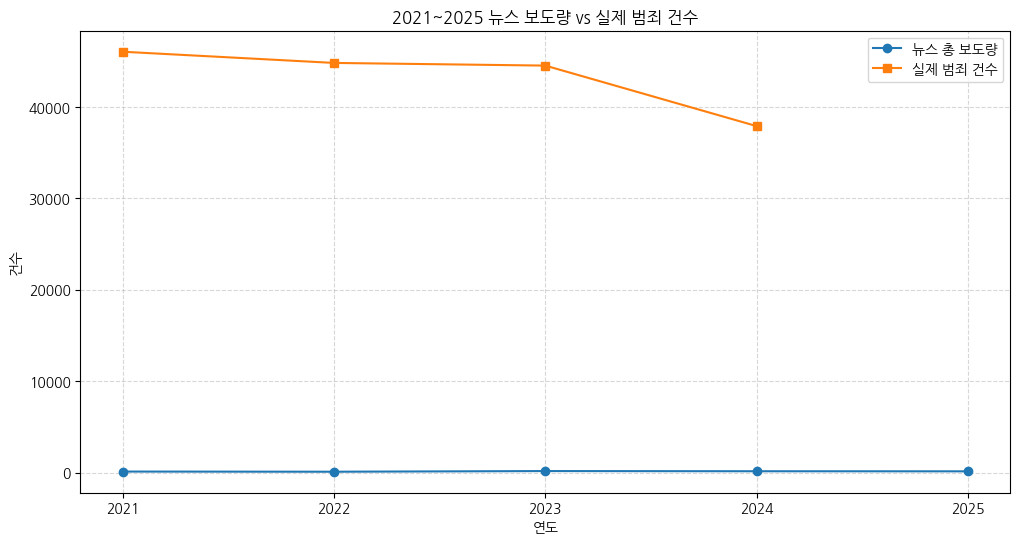

In [41]:
merged['year'] = merged['year'].astype(int)

merged = merged.sort_values('year')

plt.figure(figsize=(12,6))

plt.plot(merged['year'], merged['뉴스총보도량'], marker='o', label='뉴스 총 보도량')
plt.plot(merged['year'], merged['실제범죄건수'], marker='s', label='실제 범죄 건수')

plt.xticks([2021, 2022, 2023, 2024, 2025])

plt.xlabel('연도')
plt.ylabel('건수')
plt.title('2021~2025 뉴스 보도량 vs 실제 범죄 건수')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

/tmp/ipython-input-4241338746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['year'] = plot_df['year'].astype(int)


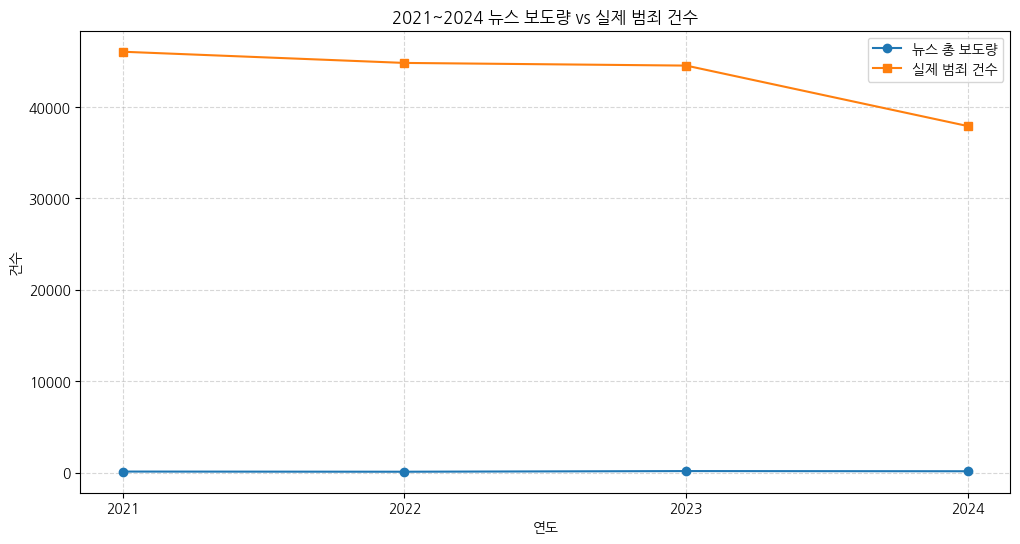

In [42]:
plot_df = merged.dropna(subset=['실제범죄건수'])
plot_df['year'] = plot_df['year'].astype(int)

plt.figure(figsize=(12,6))

plt.plot(plot_df['year'], plot_df['뉴스총보도량'], marker='o', label='뉴스 총 보도량')
plt.plot(plot_df['year'], plot_df['실제범죄건수'], marker='s', label='실제 범죄 건수')

plt.xticks(plot_df['year'])
plt.xlabel('연도')
plt.ylabel('건수')
plt.title('2021~2024 뉴스 보도량 vs 실제 범죄 건수')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()